In [107]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from torchvision import models
from torch.utils.data import random_split
import pytorch_lightning as pl
from typing import Dict, List, Union
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class DeepLabV3(pl.LightningModule):
    def __init__(self, num_classes):
        super(DeepLabV3, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=False)
        self.model = self.model.eval()
        self.criterion = nn.CrossEntropyLoss()
        self.num_classes = num_classes

    def forward(self, x):
        return self.model(x)['out']

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self(images)
        loss = self.criterion(outputs, targets)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [3]:
# Initialize the Lightning model
model = DeepLabV3(num_classes=1)

In [128]:
class HakeXarrayDatasets(Dataset):
    def __init__(self, data: Union[List[str], Dict[str, str]],
                 desired_order: List[str] = ["120 kHz", "38 kHz", "18 kHz"],
                 proportion: float=0.6):
        self.desired_order = desired_order
        self.proportion = proportion

        if isinstance(data, list):
            self.data_files = []  # Store data files in a list
            self.load_from_data_dir_list(data)
        elif isinstance(data, dict):
            self.data_files = {}  # Store key-value pairs (target file, data file)
            self.load_from_target_data_dict(data)
        else:
            raise ValueError("Invalid input type for 'data'. It should be either a list or a dictionary.")

    def load_from_target_data_dict(self, target_data_dir_dict):
        for target_path, data_path in target_data_dir_dict.items():
            target_path = Path(target_path)
            data_path = Path(data_path)

            # Get all .zarr files in the data directory
            data_files = list(data_path.glob('*.zarr'))

            for data_file in tqdm(data_files[:5]):
                self.process_target_path_and_data_file(data_file, target_path)

    def load_from_data_dir_list(self, data_dirs):
        for data_dir in data_dirs:
            data_dir = Path(data_dir)

            # Get all .zarr files in the data directory
            unchecked_data_files = list(data_dir.glob('*.zarr'))

            for data_file in tqdm(unchecked_data_files[:5]):
                # Check if Sv and channel values exist in the data file
                if self.check_data_file(data_file):
                    self.data_files.append(data_file)

    def check_data_file(self, data_file):
        try:
            # Open datasets and check for variables and desired channels
            data_ds = xr.open_dataset(data_file)
            data_channels = data_ds["Sv"].channel.values

            return all(any(partial_name in ch for ch in data_channels) for partial_name in self.desired_order)

        except KeyError as e:
            # Print KeyError and file paths
            print(f"KeyError: {e}, File Paths: {data_file}")
            return False

    def process_target_path_and_data_file(self, data_file, target_dir):
        # Extract filename without considering the path
        data_filename = data_file.name

        # Find a matching target file by filename in the target directory
        target_file = self.find_matching_target(data_filename, target_dir)

        if target_file is not None:
            try:
                # Open datasets and check for variables and desired channels
                data_ds = xr.open_dataset(data_file)
                xr.open_dataset(target_file)

                data_channels = data_ds["Sv"].channel.values

                if all(any(partial_name in ch for ch in data_channels) for partial_name in self.desired_order):
                    # If a list is initialized, store data files in a list
                    if self.data_files is None:
                        self.data_files = [data_file]
                    else:
                        # Store key-value pairs (target file, data file)
                        self.data_files[target_file] = data_file
                else:
                    print(f"Not all desired channels found in data file: {data_file}")
                    print(data_channels)

            except KeyError as e:
                # Print KeyError and file paths
                print(f"KeyError: {e}, File Paths: {data_file}, {target_file}")
                # Skip if "Sv" or "mask" variables do not exist
                pass

    def find_matching_target(self, data_filename, target_dir):
        target_files = list(target_dir.glob('*.zarr'))

        for target_file in target_files:
            if target_file.name == data_filename:
                return target_file

        return None

    def _channel_sort_by_partial_names(self, channel_name):
        for idx, partial_name in enumerate(self.desired_order):
            if partial_name in channel_name:
                return idx
        return len(self.desired_order)

    def __len__(self):
        if self.data_files is not None:
            return len(self.data_files)
        else:
            return 0
        
    def resize_data(self, data, size, mode='nearest'):
        # Resize data to the specified size using trilinear interpolation
        resized_data = F.interpolate(torch.tensor(data).unsqueeze(0).unsqueeze(0), size=size, mode=mode)
        return resized_data.squeeze().numpy()

    def __getitem__(self, idx):
        if self.data_files is not None:
            if isinstance(self.data_files, list):
                data_file = self.data_files[idx]
                data_ds = xr.open_dataset(data_file)
                data_channels = data_ds["Sv"].channel.values
                desired_data_channels = [ch for ch in data_channels if any(partial_name in ch for partial_name in self.desired_order)]

                # Get the data and resize to size (3, 256, 256)
                data = data_ds["Sv"].transpose("depth", "ping_time", "channel").sel(channel=desired_data_channels).data

                # Clipping Values
                data[:, :, :2][data[:, :, :2] < -70] = -70
                data[:, :, :][data[:, :, :] < -69] = -69
                data[data > -36] = -36

                # Normalization and Image Creation
                sv_min = np.array([-70, -70, -69]).reshape((1, 1, 3))
                sv_max = -36 
                data[np.isnan(data)] = 0.0  # Set NaN values to 0
                data = np.uint8(((data - sv_min) / (sv_max - sv_min)) * 255.0)
                data = data[:int(len(data) * self.proportion), :, :]

                data = self.resize_data(data, (512, 512, 3))

                return {
                    'data': data,
                }
            elif isinstance(self.data_files, dict):
                target_file = list(self.data_files.keys())[idx]
                data_file = self.data_files[target_file]
                data_ds = xr.open_dataset(data_file)
                data_channels = data_ds["Sv"].channel.values
                desired_data_channels = [ch for ch in data_channels if any(partial_name in ch for partial_name in self.desired_order)]

                # Get the data and resize to size (3, 256, 256)
                data = data_ds["Sv"].transpose("depth", "ping_time", "channel").sel(channel=desired_data_channels).data

                # Clipping Values
                data[:, :, :2][data[:, :, :2] < -70] = -70
                data[:, :, :][data[:, :, :] < -69] = -69
                data[data > -36] = -36

                # Normalization and Image Creation
                sv_min = np.array([-70, -70, -69]).reshape((1, 1, 3))
                sv_max = -36 
                data[np.isnan(data)] = 0.0  # Set NaN values to 0
                data = np.uint8(((data - sv_min) / (sv_max - sv_min)) * 255.0)
                data = data[:int(len(data) * self.proportion), :, :]

                data = self.resize_data(data, (512, 512, 3))

                # Mask Processing
                target = xr.open_dataset(target_file)["mask"].transpose("depth", "ping_time").data

                # Converts the mask to an 8-bit unsigned integer array
                target = np.uint8(target)
                target = target[:int(len(target) * self.proportion), :]

                # Resize data
                target = self.resize_data(target, (512, 512))

                return {
                    'data': data,
                    'target': target
                }
        else:
            raise IndexError("Index out of range. No data files available.")

100%|██████████| 5/5 [00:00<00:00, 334.48it/s]


Dataset Length: 3


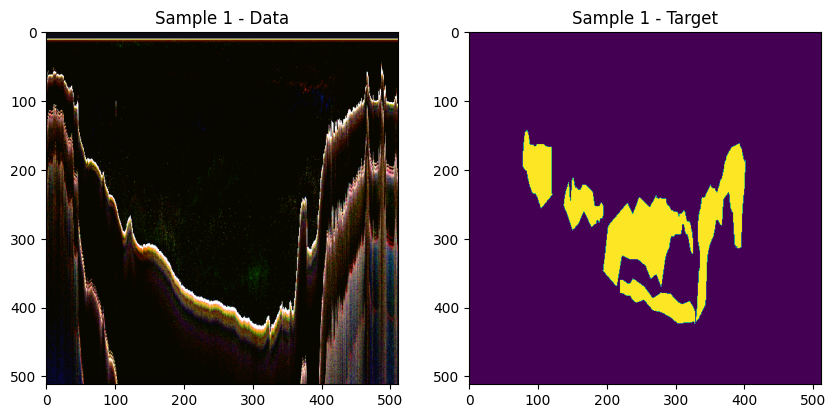

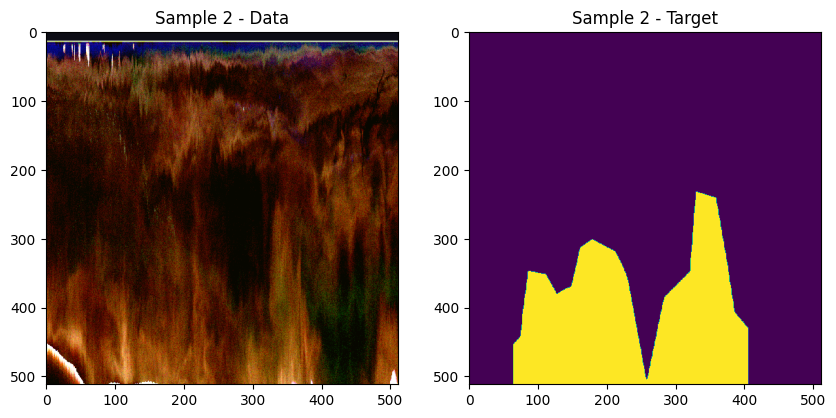

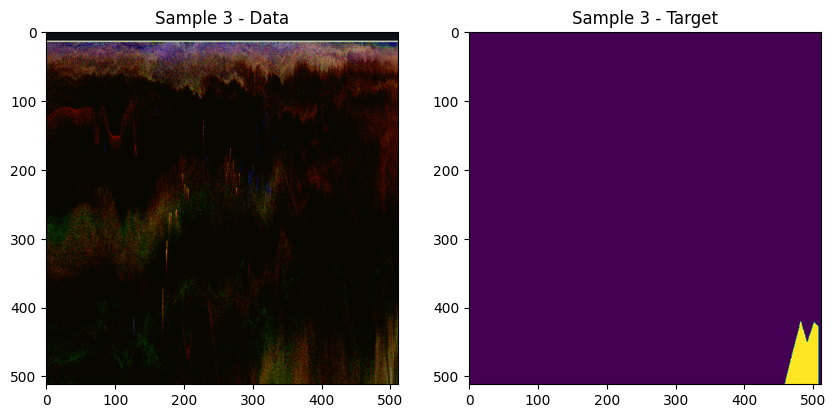

In [122]:
# Example usage dict
data_target_dir_dict = {'/home/exouser/hake_data/Sv_mask/hake/2007': '/home/exouser/hake_data/Sv_regridded/2007',
                    '/home/exouser/hake_data/Sv_mask/hake/2009': '/home/exouser/hake_data/Sv_regridded/2009'}

# Create an instance of HakeXarrayDatasets
hake_dataset = HakeXarrayDatasets(data_target_dir_dict)

# Print the length of the dataset
print("Dataset Length:", len(hake_dataset))

# Loop through the dataset and print some samples
for idx in range(len(hake_dataset)):
    sample = hake_dataset[idx]
    
    # Display the images
    plt.figure(figsize=(10, 5))
    
    # Display the data image
    plt.subplot(1, 2, 1)
    plt.imshow(sample['data'])
    plt.title(f'Sample {idx + 1} - Data')
    
    # Display the target image
    plt.subplot(1, 2, 2)
    plt.imshow(sample['target'])
    plt.title(f'Sample {idx + 1} - Target')
    
    plt.show()

100%|██████████| 5/5 [00:00<00:00, 241.96it/s]


Dataset Length: 10


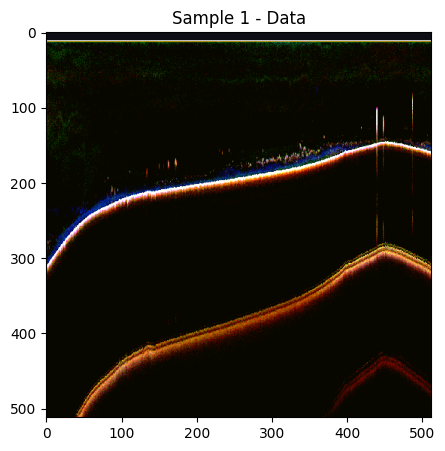

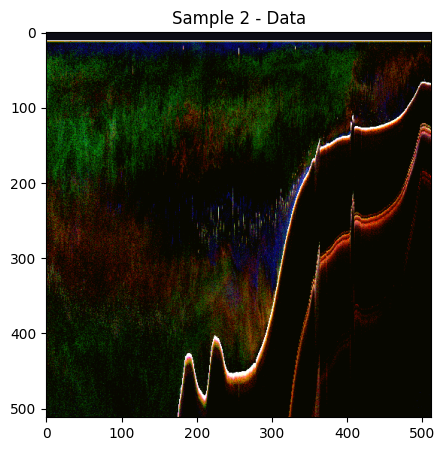

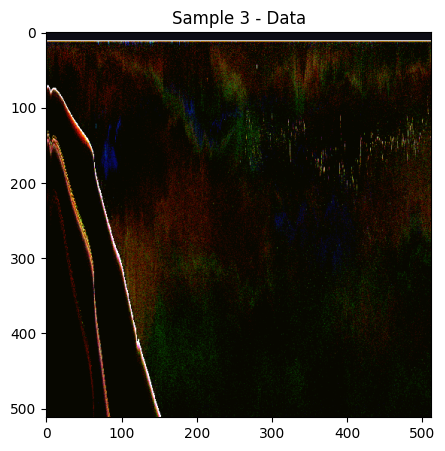

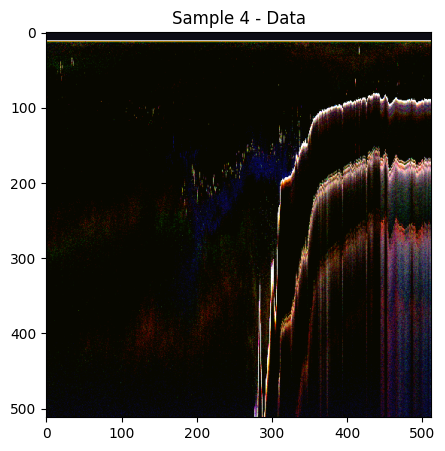

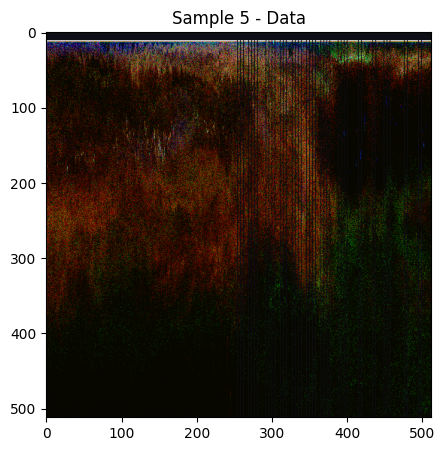

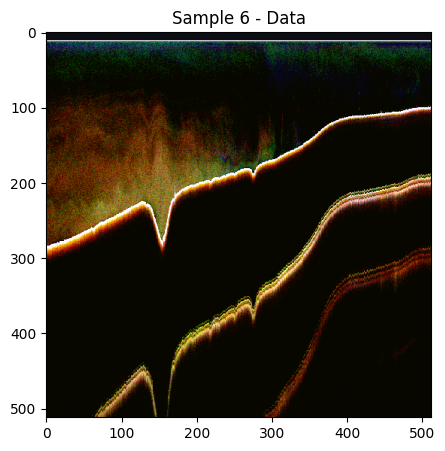

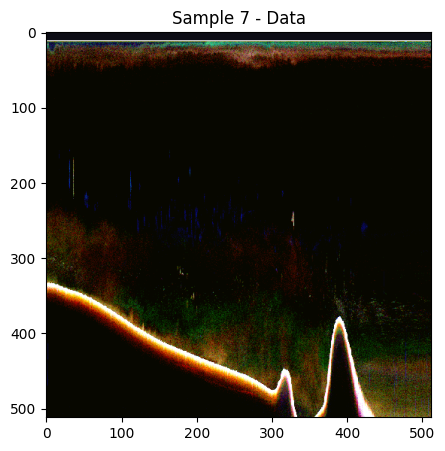

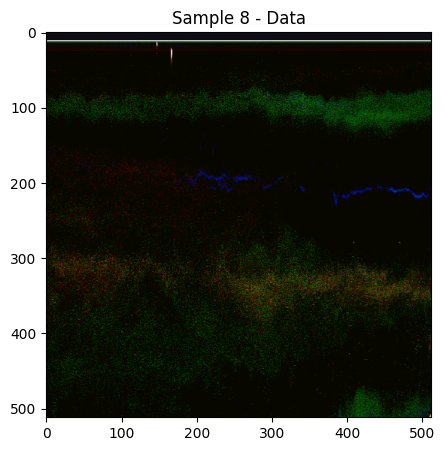

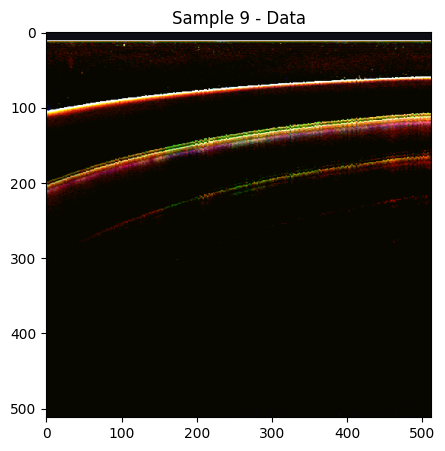

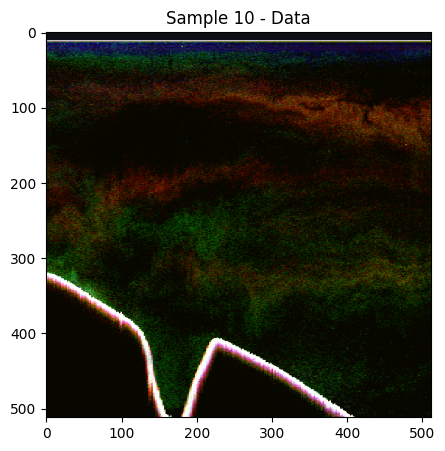

In [129]:
# Example usage list
data_dir = ['/home/exouser/hake_data/Sv_regridded/2017', '/home/exouser/hake_data/Sv_regridded/2019']

# Create an instance of HakeXarrayDatasets
hake_dataset = HakeXarrayDatasets(data_dir)

# Print the length of the dataset
print("Dataset Length:", len(hake_dataset))

# Loop through the dataset and print some samples
for idx in range(len(hake_dataset)):
    sample = hake_dataset[idx]
    
    # Display the images
    plt.figure(figsize=(5, 5))
    
    # Display the data image
    plt.subplot(1, 1, 1)
    plt.imshow(sample['data'])
    plt.title(f'Sample {idx + 1} - Data')
    
    plt.show()

In [130]:
class HakeDataModule(pl.LightningDataModule):
    def __init__(self, training_target_data_dir_dict: dict, testing_target_data_dir_dict: dict,
                 pred_dir: dict, batch_size=32, num_workers=4, validation_split=0.1):
        super(HakeDataModule, self).__init__()
        self.training_target_data_dir_dict = training_target_data_dir_dict
        self.testing_target_data_dir_dict = testing_target_data_dir_dict
        self.pred_dir = pred_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.validation_split = validation_split

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            full_train_dataset = HakeXarrayDatasets(self.training_target_data_dir_dict)
            train_size = int((1 - self.validation_split) * len(full_train_dataset))
            val_size = len(full_train_dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(full_train_dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        test_dataset = HakeXarrayDatasets(self.testing_target_data_dir_dict)
        return DataLoader(test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def pred_dataloader(self):
        pred_dataset = HakeXarrayDatasets(self.pred_dir)
        return DataLoader(pred_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [131]:
training_target_data_dir_dict = {'/home/exouser/hake_data/Sv_mask/hake/2007': '/home/exouser/hake_data/Sv_regridded/2007',
                    '/home/exouser/hake_data/Sv_mask/hake/2009': '/home/exouser/hake_data/Sv_regridded/2009'}
testing_target_data_dir_dict = {'/home/exouser/hake_data/Sv_mask/hake/20011': '/home/exouser/hake_data/Sv_regridded/20011',
                    '/home/exouser/hake_data/Sv_mask/hake/2013': '/home/exouser/hake_data/Sv_regridded/2013'}
pred_dir = ['/home/exouser/hake_data/Sv_regridded/2017', '/home/exouser/hake_data/Sv_regridded/2019']

data_module = HakeDataModule(
    training_target_data_dir_dict=training_target_data_dir_dict,
    testing_target_data_dir_dict=testing_target_data_dir_dict,
    pred_dir=pred_dir,
    batch_size=32,
    num_workers=4,
    validation_split=0.1
)

data_module.setup()

100%|██████████| 5/5 [00:00<00:00, 176.04it/s]


In [133]:
# Train DataLoader
train_dataloader = data_module.train_dataloader()
for batch_idx, batch in enumerate(train_dataloader):
    print(f"Training Batch {batch_idx + 1}:", batch)

# Validation DataLoader
val_dataloader = data_module.val_dataloader()
for batch_idx, batch in enumerate(val_dataloader):
    print(f"Validation Batch {batch_idx + 1}:", batch)

# Test DataLoader
test_dataloader = data_module.test_dataloader()
for batch_idx, batch in enumerate(test_dataloader):
    print(f"Test Batch {batch_idx + 1}:", batch)

# Prediction DataLoader
pred_dataloader = data_module.pred_dataloader()
for batch_idx, batch in enumerate(pred_dataloader):
    print(f"Prediction Batch {batch_idx + 1}:", batch)

Training Batch 1: {'data': tensor([[[[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         ...,

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [36, 38,  0],
          [37, 48,  0],
          [80, 61,  5]],

         [[ 7, 43,  0],
          [ 7, 12,  0],
          [ 7,  8,  0],
          ...,
          [42, 57,  0],
          [67, 23,  0],
          [59, 50,  7]],

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [31, 55,  0],
          [31, 68,  0],
          [90, 84,

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 153.73it/s]


Test Batch 1: {'data': tensor([[[[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         [[13, 13, 21],
          [13, 13, 21],
          [13, 13, 21],
          ...,
          [13, 13, 21],
          [13, 13, 21],
          [13, 13, 21]],

         ...,

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [ 7,  7,  0],
          [ 7, 15,  0],
          [ 7,  7,  0]],

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0]],

         [[ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0],
          ...,
          [ 7,  7,  0],
          [ 7,  7,  0],
          [ 7,  7,  0]

100%|██████████| 5/5 [00:00<00:00, 244.49it/s]


Prediction Batch 1: {'data': tensor([[[[ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21],
          ...,
          [ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21]],

         [[ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21],
          ...,
          [ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21]],

         [[ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21],
          ...,
          [ 13,  13,  21],
          [ 13,  13,  21],
          [ 13,  13,  21]],

         ...,

         [[  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0],
          ...,
          [  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0]],

         [[  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0],
          ...,
          [  7,   7,   0],
          [  7,   7,   0],
          [  7,   7,   0]],

         [[  7,   7,   0],
          [  7,   7,   0],
       